### Fist, authenticate to google and import librabies

In [95]:
# ! pip install geemap
# import geemap
import ee
import numpy as np
import pandas as pd
from pprint import pprint
from osgeo import gdal, osr

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns
import plotnine
from plotnine import *

import json
import sys
import glob

In [2]:
from google.colab import drive
drive.mount('/content/G_drive')

# cp tokens
!mkdir /root/.config/earthengine/
!cp '/content/G_drive/MyDrive/Colab Notebooks/Google_Earth_Engine_tokes/credentials' /root/.config/earthengine/credentials 

# authenticate earthengine api
ee.Initialize()

# create the tmp folder
! mkdir /content/tf_tmp

Drive already mounted at /content/G_drive; to attempt to forcibly remount, call drive.mount("/content/G_drive", force_remount=True).
mkdir: cannot create directory ‘/root/.config/earthengine/’: File exists
mkdir: cannot create directory ‘/content/tf_tmp’: File exists


In [3]:
# Tensorflow setup.
import tensorflow as tf
print(tf.__version__)

2.4.1


### Zonal statistic for the urban growth of each 256*256 path

In [34]:
# define the year-range
year = [f'{i}_{i+2}' for i in range(1990,2020,3)]
year.reverse()
year

['2017_2019',
 '2014_2016',
 '2011_2013',
 '2008_2010',
 '2005_2007',
 '2002_2004',
 '1999_2001',
 '1996_1998',
 '1993_1995',
 '1990_1992']

In [4]:
# import the urban expansion img and 256*256-grid
grid_256 = ee.FeatureCollection("users/wangjinzhulala/GEE_TF/vector_shp/fish_net_256_256")
region_mask = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classification_img/Control_1990_1992/Control_1990_1992_0").gt(-1)
urban = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/Mosaic_only_forward").updateMask(region_mask)

In [5]:
# calculate the urban growth at each 256*256 grid
grid_urban_grow = urban.reduceRegions(collection=grid_256,
                    reducer = ee.Reducer.frequencyHistogram(),
                    scale=30,
                    tileScale = 1)
# get the downloadURL
url = grid_urban_grow.getDownloadURL('csv')

# download the table
import urllib.request
urllib.request.urlretrieve(url, "/content/tf_tmp/grid_growth.csv")

('/content/tf_tmp/grid_growth.csv',
 <http.client.HTTPMessage at 0x7fc50646aa90>)

In [6]:
# formatting the histogram df, converting str-represented 
# dictionary to python-readable script
df = pd.read_csv("/content/tf_tmp/grid_growth.csv")
df = df[['Id','histogram']]
df = df[df['histogram']!='{}'] 
df['histogram'] = df['histogram'].apply(lambda x: x.replace('=',':'))
df['histogram'] = df['histogram'].apply(lambda x: eval(x))
df['Id'] = range(1,len(df)+1)
df

,Id,histogram
264,1,"{1: 7.0, 3: 6.874509803921569, 2: 1.0, 7: 8.0,..."
265,2,"{1: 40.0, 3: 14.0, 2: 12.0, 7: 10.0, 4: 32.0, ..."
266,3,"{1: 32.015686274509804, 3: 7.0, 2: 4.0, 4: 3.0..."
267,4,"{1: 17.858823529411765, 3: 17.0, 2: 32.0, 4: 3..."
444,5,"{1: 11.0, 3: 15.125490196078431, 2: 28.0, 5: 3..."
...,...,...
34637,16893,"{1: 779.6588235294117, 3: 144.72549019607843, ..."
34638,16894,"{1: 360.7450980392157, 3: 381.62745098039215, ..."
34639,16895,"{1: 739.2509803921569, 3: 382.8588235294118, 2..."
34640,16896,"{1: 60.25098039215686, 3: 185.25098039215686, ..."


In [94]:
# convert the urban-growth value of each grid to a long-format df
df_list = []
for idx,row in df.iterrows():

  # get the histogram
  id = row['Id']
  hist = row['histogram']

  # change the value to 0 if such key is not in the dict
  for key in list(set(range(11)) - hist.keys() ):
    hist[key] = 0

  # construct a dictionary to hold the value
  tmp_df = pd.DataFrame({k:[v] for k,v in hist.items()}).T
  tmp_df['Id'] = id

  # sort the index so the value are ordered from 2019 to 1990
  tmp_df = tmp_df.sort_index()

  # get the index of 1-10 becaue index-0 is background
  tmp_df = tmp_df.iloc[range(1,11)]
  tmp_df = tmp_df.reset_index(drop=True)

  # rename the df
  tmp_df.columns = ['urban_increase','Id']

  # compute the total urban area use cumulitive sum
  tmp_df['year'] = year
  tmp_df = tmp_df.sort_values(['Id','year'],ascending=[True,True])
  tmp_df['cum_count'] = tmp_df['urban_increase'].cumsum()
  

  # append the df to list
  df_list.append(tmp_df)

  # print out the process
  if (id+1)%1000 == 0:
    print(f'{id+1}/{len(df)}')


1000/16897
2000/16897
3000/16897
4000/16897
5000/16897
6000/16897
7000/16897
8000/16897
9000/16897
10000/16897
11000/16897
12000/16897
13000/16897
14000/16897
15000/16897
16000/16897


In [90]:
# concat all grid-urban-growth together
data = pd.concat(df_list)
data['year'] = data['year'].astype("category")

In [91]:
data

,urban_increase,Id,year,cum_count
9,2.0,1,1990_1992,2.0
8,2.0,1,1993_1995,4.0
7,0.0,1,1996_1998,4.0
6,8.0,1,1999_2001,12.0
5,0.0,1,2002_2004,12.0
...,...,...,...,...
4,0.0,16897,2005_2007,0.0
3,0.0,16897,2008_2010,0.0
2,0.0,16897,2011_2013,0.0
1,0.0,16897,2014_2016,0.0


In [93]:
df_list[5500].reset_index()

,index,urban_increase,Id,year,cum_count
0,9,3163.078431,5501,1990_1992,3163.078431
1,8,679.823529,5501,1993_1995,3842.901961
2,7,518.349020,5501,1996_1998,4361.250980
3,6,387.501961,5501,1999_2001,4748.752941
4,5,159.741176,5501,2002_2004,4908.494118
5,4,501.250980,5501,2005_2007,5409.745098
6,3,220.498039,5501,2008_2010,5630.243137
7,2,236.874510,5501,2011_2013,5867.117647
8,1,544.368627,5501,2014_2016,6411.486275
9,0,693.458824,5501,2017_2019,7104.945098


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


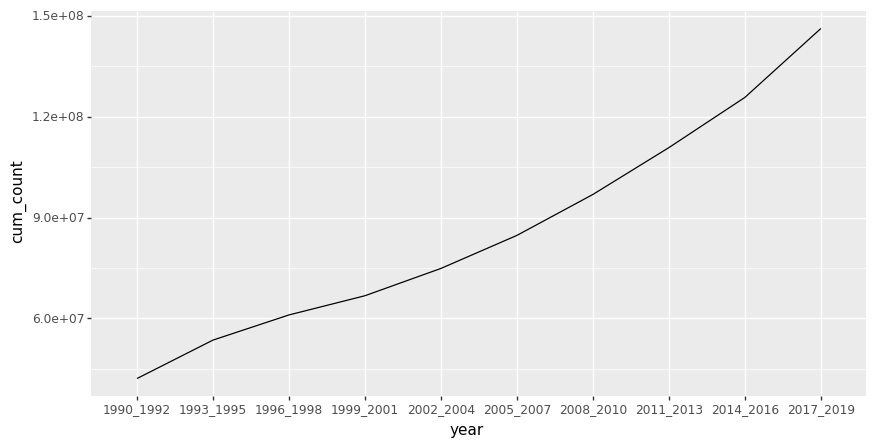

<ggplot: (8780234652121)>

In [81]:
# sanity check with the totall area.
plotnine.options.figure_size = (10, 5)

(data.groupby('year').sum().reset_index()>>
 ggplot()+
 geom_line(aes('year','cum_count',group=1))+
 scale_y_continuous(labels=scientific_format(digits=3)))

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


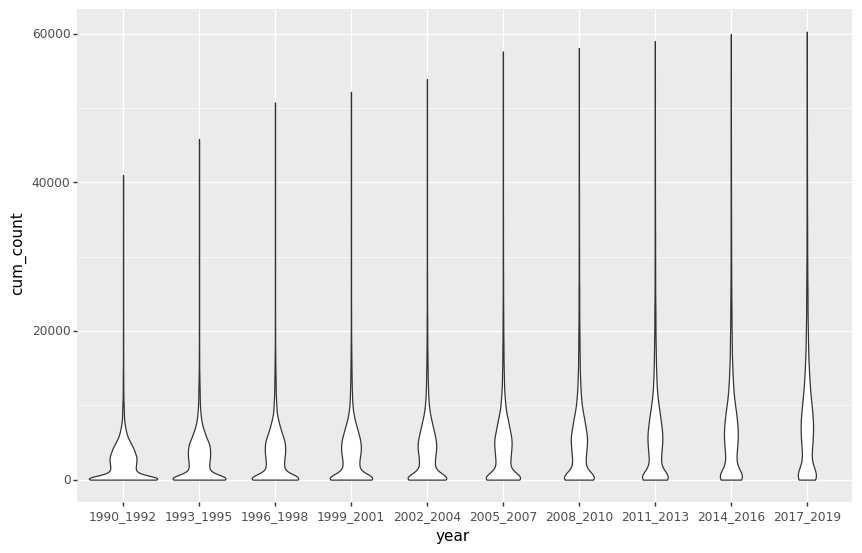

<ggplot: (8780234755857)>

In [80]:
(data>>
 ggplot()+
 geom_violin(aes('year','cum_count'))
)